# Handwritten Document Conversion

July 19, 2024

## Setup Env

In [2]:
!python --version

Python 3.11.8


### Install packages

```bash
pip install layoutparser
pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
```

Layout parse -> 1. Text detection and 2. Layout detection

### Import modules

In [2]:
import layoutparser as lp
import numpy as np
import pandas as pd
import cv2 as cv
import pathlib
import os
import requests
import copy
import pytesseract
from PIL import Image
from layoutparser.models.detectron2 import catalog
from matplotlib import pyplot as plt
from random import randrange

In [15]:
def load_model(config_path: str='lp://<dataset_name>/<model_name>/config', extra_config=None):
    config_path_split = config_path.split('/')
    dataset_name = config_path_split[-3]
    model_name = config_path_split[-2]

    # get the URLs from the MODEL_CATALOG and the CONFIG_CATALOG 
    # (global variables .../layoutparser/models/detectron2/catalog.py)
    model_url = catalog.MODEL_CATALOG[dataset_name][model_name]
    config_url = catalog.CONFIG_CATALOG[dataset_name][model_name]

    # override folder destination:
    if 'model' not in os.listdir():
        os.mkdir('model')

    config_file_path, model_file_path = None, None

    for url in [model_url, config_url]:
        filename = url.split('/')[-1].split('?')[0]
        save_to_path = f"model/" + filename
        if 'config' in filename:
            config_file_path = copy.deepcopy(save_to_path)
        if 'model_final' in filename:
            model_file_path = copy.deepcopy(save_to_path)

        # skip if file exist in path
        if filename in os.listdir("model"):
            continue
        # Download file from URL
        r = requests.get(url, stream=True, headers={'user-agent': 'Wget/1.16 (linux-gnu)'})

        with open(save_to_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=4096):
                if chunk:
                    f.write(chunk)

    # load the label map
    label_map = catalog.LABEL_MAP_CATALOG[dataset_name]
    print(config_path, model_file_path)

    return lp.models.Detectron2LayoutModel(
        config_path=config_file_path,
        model_path=model_file_path,
        label_map=label_map,
        extra_config=extra_config
    ), model_name

### Import dset

Dataset description.

In [6]:
dset=pathlib.Path.home().joinpath('projects/Handwritten-Document-Conversion/data')
test=dset.joinpath('test')
test

PosixPath('/home/nikin/projects/Handwritten-Document-Conversion/data/test')

In [6]:
# images = [cv.cvtColor(cv.imread(test.joinpath(img).as_posix()), cv.COLOR_BGR2RGB) for img in test.iterdir()]
images = [ cv.imread(img_path.as_posix()) for img_path in test.iterdir() ]

## Modeling

> [Layout Parser Model Zoo](https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html7)

The config path of a spectrum of pre-trained models trained on different dataset are stored in `modelzoo.txt`

In [9]:
with open('./zoo.txt', 'r') as zoo:
    config_path = [line.rstrip('\n') for line in zoo]

### Initiate Detectron2LayoutModel and parse the image

In [11]:
def parseLayout(image, config_path, extra_config=None):
    model, name = load_model(config_path, extra_config=extra_config)
    layout=model.detect(image)
    color_map = { 'Text': 'red', 'Title': 'blue', 'List': 'green', 'Table': 'purple', 'Figure': 'pink' }
    output = lp.visualization.draw_box(canvas=image, layout=layout, box_width=10, color_map=color_map)
    print(type(output))
    output.save("./layout.png")
    plt.imshow(output)
    plt.axis('off')
    return layout, name

(-0.5, 4127.5, 2321.5, -0.5)

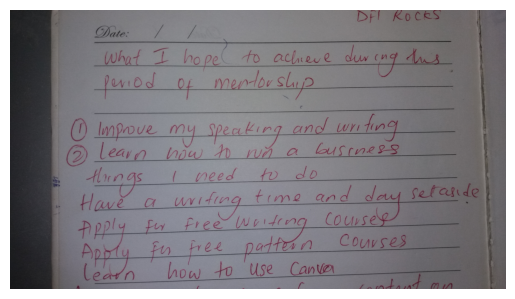

In [12]:
## Specify an image whose layout is to be parsed
#randIndex = randrange(0, len(images)); print(randIndex)
# img = images[27]
img=cv.imread(test.joinpath('eng_AF_004.jpg').as_posix())
# Change to RGB
img = img[..., ::-1]
plt.imshow(img)
plt.axis('off')

lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config model/model_final.pth


/home/nikin/.conda/envs/detectron2/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locat

<class 'PIL.Image.Image'>


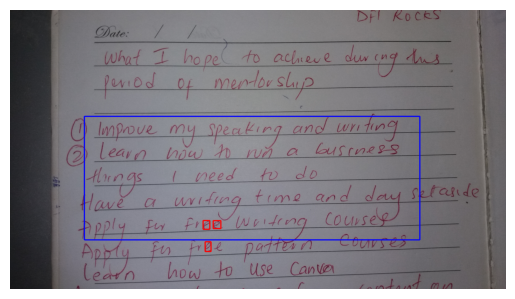

In [16]:
# Specify the model and parse
model = config_path[3]
threshold = 0.7
layout, model_name = parseLayout(img, model, ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", threshold])

In [13]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)
# See https://github.com/pytorch/vision/?tab=readme-ov-file#installation for compatibility.

2.4.0+cu121
0.19.0+cu121


It's more desirable that individual paragraphs are detected. So Let's run another model.

In [14]:
# Specify the model and parse
model = config_path[1]
threshold = 0.5
layout, model_name = parseLayout(img, model, ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", threshold])

NameError: name 'model_path' is not defined

Let's try to extract the text from the detected layouts.

### Initiate Tesseract OCR Engine and try to extract text

Ensure tesseract is installed system-wide.

In [12]:
!which tesseract

/usr/bin/tesseract


In [13]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [14]:
def extract_text(image, b, padding=None):
    boundary = [b.block.x_1, b.block.y_1, b.block.x_2, b.block.y_2]
    # TODO optimize the padding parameter like CSS
    if padding:
        boundary = [item + padding for item in boundary]
    left, top, right, bottom = map(int, boundary)
    cropped_image = img[top:bottom, left:right]
    extracted_text =  ocr_agent.detect(cropped_image)
    return cropped_image, extracted_text

In [15]:
blocks = [b for b in layout]
for i, block in enumerate(blocks):
        print(block.type, i)

Page Frame 0
Other 1
Other 2
Other 3
Other 4
Other 5
Other 6
Other 7
Other 8
Other 9
Other 10
Page Frame 11
Page Frame 12
Other 13
Page Frame 14


(-0.5, 2790.5, 1028.5, -0.5)

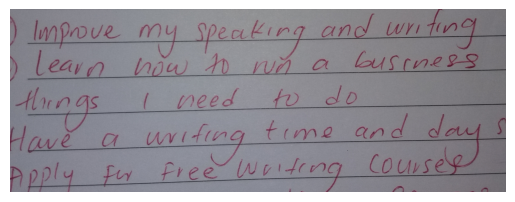

In [16]:
frame, extracted_text = extract_text(img, blocks[0], padding=-16)
(Image.fromarray(frame)).save("./frame.png")
plt.imshow(frame)
plt.axis('off')

In [17]:
print(extracted_text)

) mpove My Speclirg and wridindg s
/f/?mgs need fi
Howé o (A/w/m time and d

P;O( . D e CO(/U/H’, "“‘

P o P




* Tesseract works well with scanned images of **printed text**. So, **as long as a proper layout is
being detected**, tesseract's OCR can be used for text extraction.

* However, tesseract does not perform very well on images of handwritten text. Below is an example.

The result in the above image is still not bad; beacuse the handwriting is 
rather clear and non-cursive. Let's try on another image.

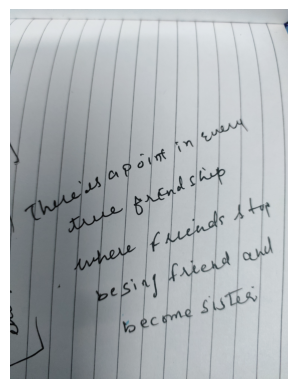

In [19]:
img=images[28]
plt.imshow(img)
plt.axis('off')
(Image.fromarray(img)).save('z.png')

In [20]:
print(ocr_agent.detect(img))

————————— S —— O iRt B i —
e . .

s el

e —— o "
S -
i sam s e st sont'

” B

i
g

S A s o oot
e — R ———————————

L) o

e

ey




In [ ]:
def log():
    with open('./performance.csv', 'a+') as performance:
        content = f"{model_name},{threshold}\n"
        performance.write(content)

In [ ]:
log()

## Performance